# Combining different models for ensemble learning

**This is chapter 7 of the Python Machine Learning book written by Sebastian Raschka. The code is from his book, I played around and enriched it with texts and explanation from the book and/or other resources to have both code + explanations combined** 

- Make predictions based on majority voting
- reduce overfitting by drawing random combinations of the training set with repetitions
- build powerful models from **weak learners** that learn from their mistakes

### Learning with ensembles

goal behind **ensemble methods** is to combine different classifiers into a meta-classifier that has a better generalization preformance than each individual classifier alone. Here we will focus on the most popular ensenble metods that use **majority voting** (referring to binary class settings only) meaning the selection of class labels that have been selected by the majority of the classifier and received more than 50% of the votes.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import comb # the number of combinations of N things taken k at a time.
import math
import numpy as np

In [2]:
def ensemble_error(n_classifier, error):
    """ 
    to compare an idealistic ensemble classifier to a base classifier over a range of different base error rates
    """
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
# side) try out comb http://calculator.tutorvista.com/n-choose-k-calculator.html
k = np.array([3, 4])
n = np.array([10, 10])
comb(n, k, exact=False)

array([ 120.,  210.])

In [4]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

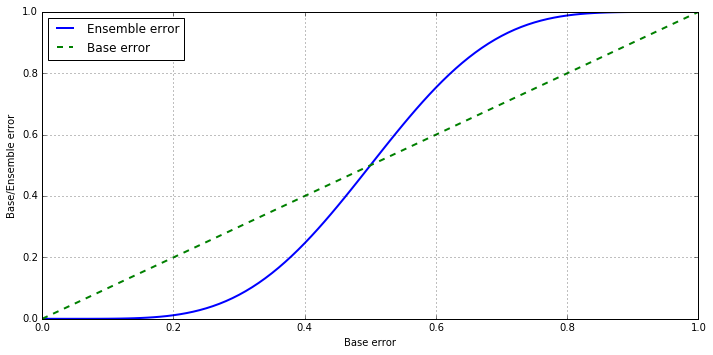

In [5]:
fig, ax  = plt.subplots(figsize = [10,5])
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

plt.plot(error_range, ens_errors, 
         label='Ensemble error', linewidth=2)

plt.plot(error_range, error_range, linestyle='--',
         label='Base error', linewidth=2)

plt.xlabel('Base error'); plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(); plt.tight_layout()

This basically tells us that the error probability of an ensemble is always better than the error of an individual base classifier as long is this performs better than random guessing

### Implementing a simple majority vote classifier

The algorithm implemented here will allow us to combine different classification algorithms associated with individual weights for confidence. Our goal is to build a stronger meta-classifier that balances out the individual classifiers' weaknesses on a particular dataset. 

In [6]:
# we'll be using np.bincount frequently so an example:
x = np.array([1,1,1,2,2,2,5,6,1,1])
y = np.bincount(x) # Count number of occurrences of each value in array of non-negative ints.

In [7]:
y

array([0, 5, 3, 0, 0, 1, 1], dtype=int64)

In [8]:
# to translate the concpet of weighted majority we can use a comb of np.bincount and argmax
np.argmax(np.bincount([0,0,1], weights = [.2, .2, .6]))  # Returns the indices of the maximum values along an axis.

1

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X. Predict method predicts class labels via maority vote 
        based on the class labels if we initialize a new MajorityVoteClassifier object with vote = 'classlabel'.
        

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X. (useful for calculating the ROC/AUC)

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### Combining different algorithmsfor classification with majority vote

Although our MajorityVoteClassifier() generilizes to multiclass problems we'll take the Iris dataset and only classify flower samples from the 2 classes Iris-Versicolor and Iris-Virginica to compute the ROC-AUC:

In [22]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()

In [21]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state = 1)

In [34]:
clf1 = LogisticRegression(penalty='l2', C = 0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]]) # uses the Eucledian distance metric so standardized scaling is good practise
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]]) #uses the Eucledian distance metric so standardized scaling is good practise
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print ('10-fold cv:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X = X_train, y= y_train, cv= 10, scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cv:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [44]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority voting]


### Evaluating and tuning the ensemble classifier

compute the ROC curves from the test set to ceck if the MajorityVotingClassifier() generalizes well on unseen data. Remeber that the test set is not to be used for model selection: it`s only purpose is to report an unbiased estimate of the generalization performance of a classifier system. 

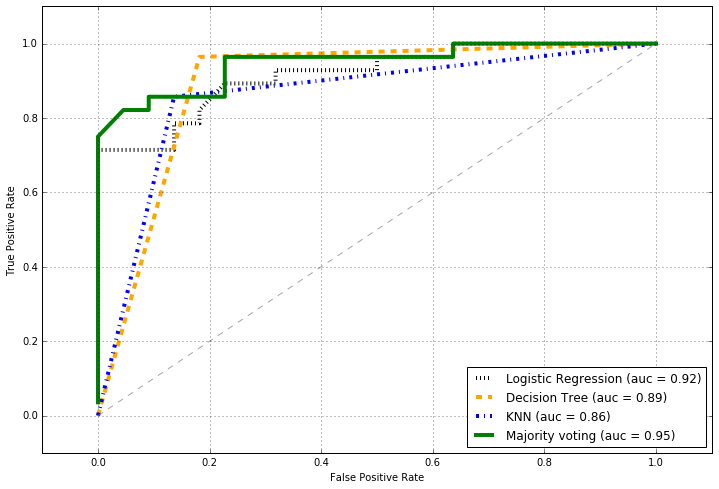

In [67]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

fi, ax = plt.subplots(figsize=[12,8])

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming positive class label is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_true = y_test, 
                                   y_score = y_pred)
    roc_auc = auc(x= fpr, y =tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, lw=4,
            label = '%s (auc = %.2f)' % (label, roc_auc))
plt.legend(loc='lower right'); plt.grid()
plt.plot([0,1], [0,1], linestyle = '--', color = 'grey', alpha=.7)
plt.xlim([-0.1, 1.1]); plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')

As we can see the ensemble classifier also performs well on the test set (ROC AUC =.95), whereas the KNN classifier seems to be overitting the training data (training ROC AUC was .93, and here on the test data it is .86).


Now lets see the decision boundary of the ensemble classifier against the other algorithms. Although it is not necessary to standardize the training features prior to model fitting (the LogisticRegression() and KNN() pipelines already take care of this, we will standardze so that the decision boundary visualizations are on the same scale and can be nicely compared:


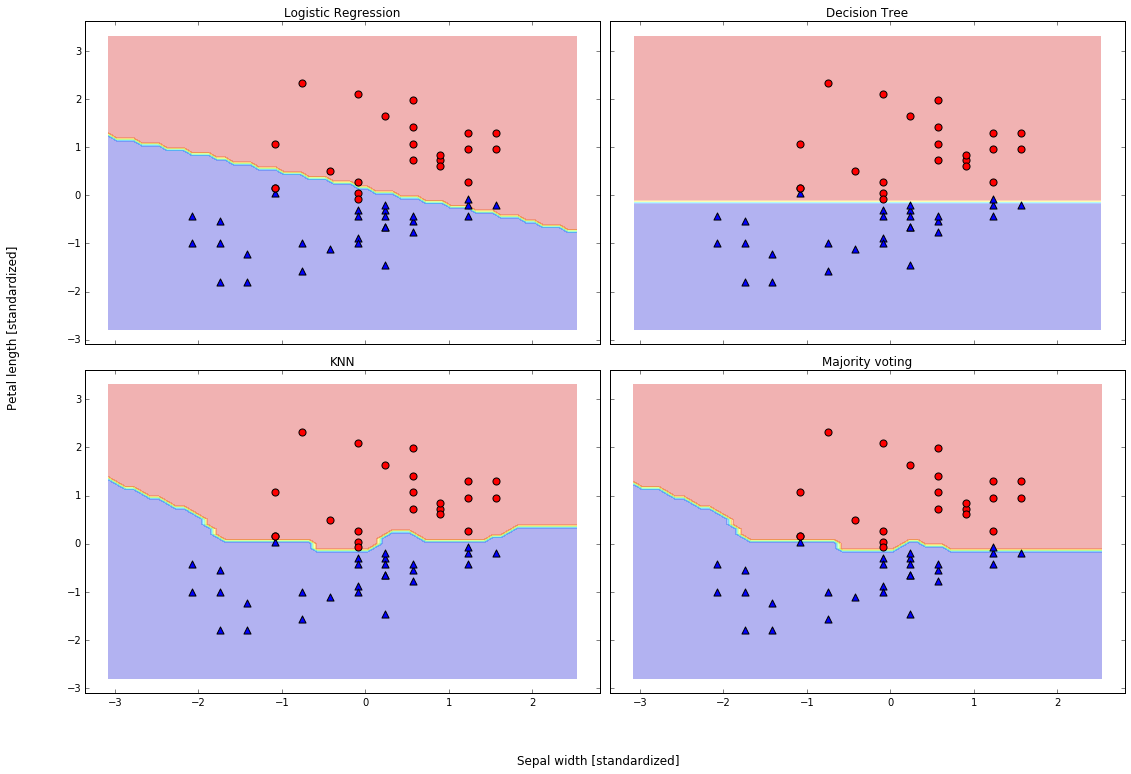

In [98]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),  # meshgrid = Return coordinate matrices from coordinate vectors.
                     np.arange(y_min, y_max,.1))
f, axarr = plt.subplots(nrows=2, ncols=2, figsize= [15,10], sharey='row', sharex = 'col')

for idx, clf, tt in zip(product([0, 1], [0, 1]), # gives: [(0, 0), (0, 1), (1, 0), (1, 1)] referring to the grid objects
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # **
    ## np.c_ = Translates slice objects to concatenation along the second axis.
    Z = Z.reshape(xx.shape) # otherwise TypeError will beraised: Input z must be a 2D array. 

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()

Decision boundaries are a hybrid of the individual classifier. 

In [91]:
# ** 
[xx.ravel(), yy.ravel()]

[array([-3.07478921, -2.97478921, -2.87478921, ...,  2.32521079,
         2.42521079,  2.52521079]),
 array([-2.79369815, -2.79369815, -2.79369815, ...,  3.30630185,
         3.30630185,  3.30630185])]

In [92]:
np.c_[xx.ravel(), yy.ravel()]

array([[-3.07478921, -2.79369815],
       [-2.97478921, -2.79369815],
       [-2.87478921, -2.79369815],
       ..., 
       [ 2.32521079,  3.30630185],
       [ 2.42521079,  3.30630185],
       [ 2.52521079,  3.30630185]])

In [109]:
# to access the indivual parameters of the GridSearch object
mv_clf.get_params(deep = True)

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=

**Let's tune the inverse regularization parameter C of he LogisticRegression() classifier and the DecisionTree depth via the gridsearch for demo purposes: **


In [114]:
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100]} # take the exact notation as stated in the get_params()!!
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pipeline-1__clf__C': [0.001, 0.1, 100], 'decisiontreeclassifier__max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [116]:
# to get the grid scores:
grid.grid_scores_

[mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1},
 mean: 1.00000, std: 0.00000, params: {'pipeline-1__clf__C': 100, 'decisiontreeclassifier__max_depth': 1},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2},
 mean: 0.96667, std: 0.10000, params: {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2},
 mean: 1.00000, std: 0.00000, params: {'pipeline-1__clf__C': 100, 'decisiontreeclassifier__max_depth': 2}]

In [125]:
# after the grid search has been completed, we can print the different hyper parameter value combinations 
# and the average ROC_AUC scores computed via the 10-fold cv:
for params, mean_score, scores in grid.grid_scores_: 
    print ('%.3f+/-%.2f %r' % (mean_score, scores.std()/2, params))

0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000+/-0.00 {'pipeline-1__clf__C': 100, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000+/-0.00 {'pipeline-1__clf__C': 100, 'decisiontreeclassifier__max_depth': 2}


In [130]:
# to get he best parameter + score:
print ('Best parameter: {}' .format(grid.best_params_))
print ('Best score: {}'.format(grid.best_score_))

Best parameter: {'pipeline-1__clf__C': 100, 'decisiontreeclassifier__max_depth': 1}
Best score: 1.0


### Bagging - building a ensemble of classifiers from bootstrap samples

Bagging is closely related to the MajorityVotingClassifier() that we've just seen but instead of using the same training set to fit the indivdual classifiers, we draw **bootstrap samples** from the initial training set, which is why bootstrapping is also known as **bootstrap aggregate** 

- in fact RandomForests are a special case of bagging where we also use random feature subsets to fit the individual decision trees.

In [133]:
## to see the baging in action let's create a more complex classification problem
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [141]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

In [156]:
# baggingclassifier algorithm already implemented in sklearn. Here use an unpruned decision tress as base classifier 
# and create an ensemble of 500 decision trees fitted on different bootstrap samples of the training dataset
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.896


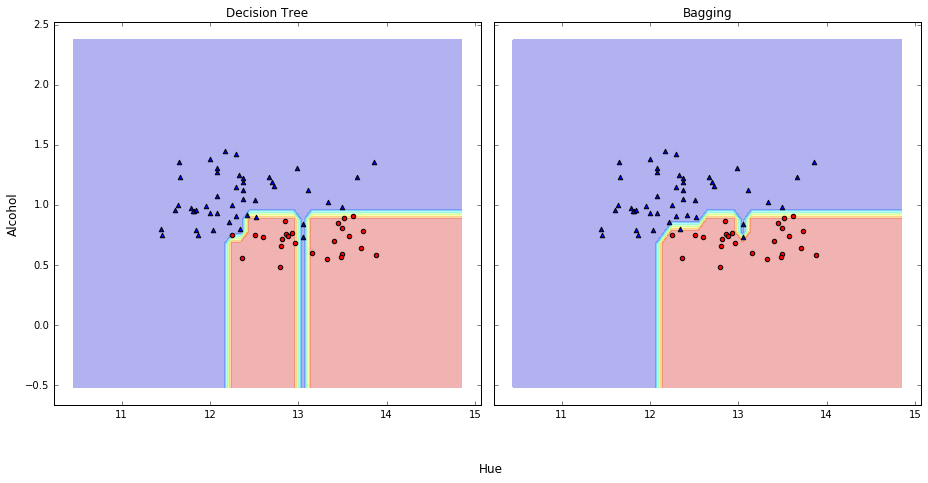

In [162]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(13, 6))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()

This plot shows that the bagging ensemble smoothes out better. This was a very simple example but in more complex classification tasks and high dimensionality in datasets single decision trees can easily lead to overfitting  and this is were bagging algorithms can consistently deliver!....

- also note that the bagging algorithm can be an method in reducing variance in a model.
- however bagging is uneffective in reducing model bias, which is why we would like to choose an ensemble of classifier with low bias , fi, unpruned decision trees. 

### Leveraging weak learners via adaptive boosting

** boosting / adaptive boosting **

in boosting, the ensemble consists of very somple base classifiers, aso referred to as ** weak learners**, that have only a lsght performance advantage over random guessing. A typical example of a weak learner would be a decision tree stump. They key concept behind boosting is to focus on training samples tha are hard to classify , that is, to let **the weak learners subsequently learn from misclassified training samples to improve the preformance of the ensemble**.

- in contrast to bagging, the initial formulation of boosting, the algorithm uses random subsets of training samples drawn from the training set w/o replacement.

This is the flow:
- draw random subset of training samples d1 w/o replacement to train a weak learner C1
- draw second random training subset d2 w/o replacement from the training set and add 50% of the samples that were previsouly misclassified to train a weak learner C2
- Find the training samples d3 in the training set D on wich C1 + C2 disagree to rain a 3rd weak learner C3
- combine the weak learners C1, C2ad C3 via majority voting

bossting can lead to a **decrease in bias as well as variance** compared to bagging. In practise, however, Adaboost fi is known for high variance, that is the tendency to overfit the training data. **ADABOOST** uses the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier that learsn from the mistakes of the previsous weak learners in the ensemble. 

In [170]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion ='entropy', max_depth =1)
ada= AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=.1, random_state=0)

tree= tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print ('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


the decision tree stump seems to overfit the training data in contrast with the unpruned decision trees that we saw in the previsou section. The Adaboost model predicts all class labels correctly on the training set and also shows some improement on the test set compared to the decision tree stump. 


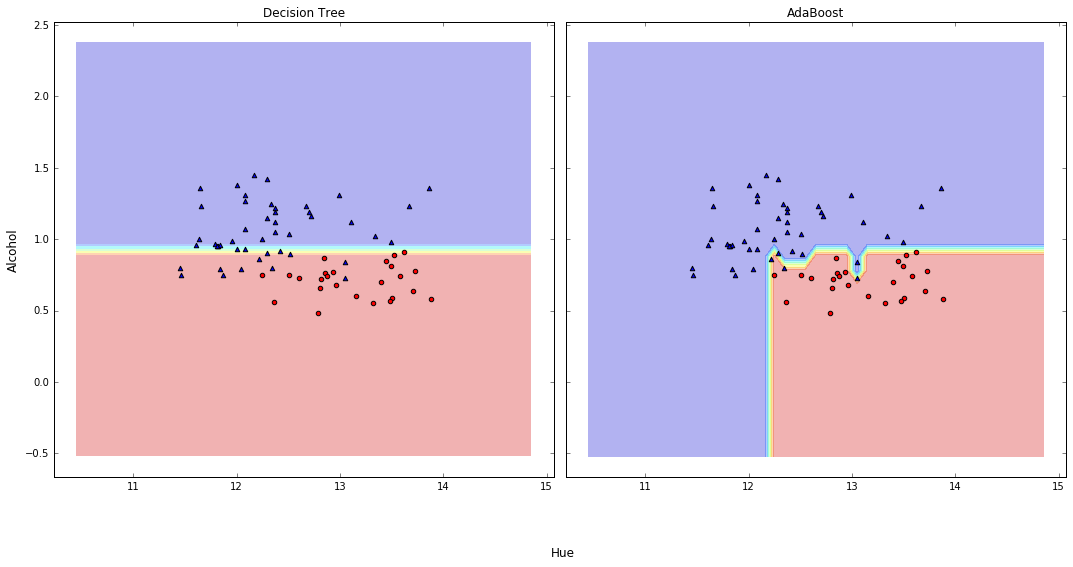

In [174]:
# check the decision boundaries:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 7))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()

we can see that the decision regions of the Adaboost is substantially more complex than the boundaries of the decision tree stumps.  

- final remarks: ensemble techniques can be computationally expensive for often relatively modest improvements of the predictive performance. 

- An often cited exmaple of ensemble techniques are the 1MIO Netflix prize which was won using ensemble techniques. 